<a href="https://colab.research.google.com/github/Thabet-Chaaouri/Sentence_similarity/blob/main/Clustering_sb_Betropic_usage%26Pipeline_def.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Parcours utilisateurs:
- Je découvre les thématiques
- une thématique m'intéresse, je vérifie son entourage et ses chevauchements
- Zoom in sur les Story bin attachés à ce Thématique

# Setup

In [ ]:
!pip install transformers[agents] datasets bertopic
!pip install -U sentence-transformers
!pip install einops
!pip install accelerate bitsandbytes
!pip install wordcloud
!pip install keybert
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.9/19.9 MB 73.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.1/288.1 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

# Data loading

In [ ]:
from datasets import load_dataset

dataset = load_dataset("Thabet/data_clustering_sb")
dataset

  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['Title_sb', 'Id_sb', 'Id_container', 'Type_sb', 'Nature_sb', 'Couverture_sb', 'Summary_sb', 'Lieu_sb', 'Origin_sb', 'Redacteur_sb', 'Destination_sb', 'Categorie_sb', 'date_creation', 'Status_sb', 'length_title', 'Text_sb', 'week', 'year', '__index_level_0__'],
        num_rows: 125367
    })
})

# Model fitting

### Tricks to Try

###Done
- delete keywords Titre & Résumé ==> Done
- use french stopwords ==>Done
- Discard all text that uses ww. or .com ==> Done
- Discard date jj/mm,  ==> Done
- Discard f2, f3, sjt, Snumber, S_number, DLR_NUMBER, DLRNumber, CI_IOLS, ROD_,USB_ ==> DONE
- change _ with space ==> Done
- keep title longer than 2 words. do split on space ==> Done
- Tried clustering on samples 10000 sb, then Tried weekly clustering ==> Done. Clustering still very poor with too much outliers whithin clusters
- Tried clustering  first with titles + summaries, then without using Summaries ==> Done. summaries are not always present, so when it is present, it introduces bias during Topic representation. 
- Tried different models for embeddings ==> Done. Best one was the cohere model because it was well trained on french language.
- Fine tune one selected model ==> Done. selected the-all mpnet-base-v2, clustering got better and gave similar results to the cohere model.
- Tried Agents and some LLMs to improve clustring. ==> for the task of clustering agents is not the solution as it is only one defined task so it would be better to use an efficient LLM that works well on french and accepts long inputs. ChatGPT is the best answer

###Todo
- improve further the clustring model through an iterative process : add data - clean data - choose model - finetune it - do clustering - compute a metric

- improve the clustering with openAI API or train its own LLM

- Use an agent to continue the user journey behing discovery to search on the net and story writing assistant


# Weekly topic modeling on Titles only using all-mpnet-base-v2

In [ ]:
# Filter the dataset based on a column value
filtered_dataset = dataset.filter(lambda example: (example["week"] == 20) & (example["year"] == 2023) & (not example["Origin_sb"].startswith("RN")))
filtered_dataset

DatasetDict({
    train: Dataset({
        features: ['Title_sb', 'Id_sb', 'Id_container', 'Type_sb', 'Nature_sb', 'Couverture_sb', 'Summary_sb', 'Lieu_sb', 'Origin_sb', 'Redacteur_sb', 'Destination_sb', 'Categorie_sb', 'date_creation', 'Status_sb', 'length_title', 'Text_sb', 'week', 'year', '__index_level_0__'],
        num_rows: 1587
    })
})

In [ ]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from spacy.lang.fr.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP

model_ckpt = "Thabet/all-mpnet-base-v2_for_sb_clustering"

embedding_model = SentenceTransformer(model_ckpt)

french_stopwords = list(STOP_WORDS) 
vectorizer_model = CountVectorizer(stop_words=french_stopwords, ngram_range=(1, 2),)

umap_model = UMAP(n_neighbors=15, n_components=20, metric='cosine', low_memory=False)

topic_model = BERTopic(embedding_model=embedding_model, vectorizer_model=vectorizer_model, umap_model=umap_model)
docs = filtered_dataset["train"]["Text_sb"]
topics, probs = topic_model.fit_transform(docs)

In [ ]:
freq = topic_model.get_topic_info()
freq

,Topic,Count,Name,Representation,Representative_Docs
0,-1,726,-1_fête_2023_off_jours,"[fête, 2023, off, jours, rue, incarne, vente, ...","[ - journée mondiale des abeilles, : fête Jean..."
1,0,111,0_rugby_foot_match_championnat,"[rugby, foot, match, championnat, ligue, footb...",[ – /Itw Match caritatif anciens joueu / FC ...
2,1,92,1_festival_cannes_jazz_concert,"[festival, cannes, jazz, concert, édition, fes...","[ Festival de cannes depuis le Rialto à , / / ..."
3,2,53,2_ascension_tourisme_week_week end,"[ascension, tourisme, week, week end, end, end...","[ DEPARTS WEEK-END ASCENSION, WEEK-END ASCENSI..."
4,3,53,3_culture_musée_château_monument,"[culture, musée, château, monument, expo, chat...","[/ Musée -O, - Desk musée des Beaux Arts de..."
5,4,47,4_eau_secheresse_climat_alerte,"[eau, secheresse, climat, alerte, climatique, ...",[ : La mairie de Peymieux achète des récupérat...
6,5,45,5_affaire_tribunal_procès_agression,"[affaire, tribunal, procès, agression, trogneu...","[ PROJET PERMIS DE ?CONDUIRE A 16 ANS, N. SARK..."
7,6,44,6_non_soignants non_soignants_vaccinés,"[non, soignants non, soignants, vaccinés, non ...","[ Témoignage reprise soignants non vaccinés, -..."
8,7,42,7_école_college_lycée_îlot verdure,"[école, college, lycée, îlot verdure, écoles, ...","[ ÎLOT DE VERDURE COLLEGE MONTAIGNE, 24P ÎLOT ..."
9,8,42,8_portrait_elodie_françois_invité,"[portrait, elodie, françois, invité, 01, elodi...","[ PORTRAIT ELODIE GODIN TEUSE RETRAITE, 1A Fr..."


In [ ]:
type(topic_model.visualize_topics())

plotly.graph_objs._figure.Figure

In [ ]:
topic_model.get_topic(17)

[('maires', 0.2437238928067834),
 ('maire', 0.20738582801100208),
 ('dep', 0.07311716784203502),
 ('veyrac', 0.06902318673812399),
 ('démission', 0.06902318673812399),
 ('dep démission', 0.06902318673812399),
 ('démission maires', 0.06902318673812399),
 ('maire veyrac', 0.06902318673812399),
 ('contre', 0.051237641132180635),
 ('maire lr', 0.03891240498576029)]

In [ ]:
df_document_info = topic_model.get_document_info(docs)
list(df_document_info.loc[df_document_info.Topic==17].Document)

['Colère des maires : Réaction maire de Veyrac contre incivilité',
 'MAIRE DE VEYRAC INCIVILITEES',
 ' LES MAIRES DEMISSIONNAIRES TEMOIGNENT',
 ' - Incivilités contre la mairie de Drap',
 'DEP - Démission des maires (/23)',
 'INCIVILITES CONTRE MAIRE DE DONZY ',
 ' MAIRE DE VALENCAY RAS LE BOL DES MAIRES',
 'DEP Nicas Daragon, Maire LR de   ',
 ' IV3 DESARROI MAIRE',
 ' / MAIRES : POURQUOI DES DÉMISSIONS EN HAUSSE ?',
 "  VISIO ASSOCIATION MAIRES DE L'INDRE",
 'Journée Paris Maire St Brevin Sénat et Matignon',
 ' PLAINTE MAIRE DE MONTARGIS SUITE BANDEROLE MENACANTE ',
 ' MAIRES MENACES DREUX',
 ' ENQUETE CORRUPTION PASSIVE MAIRE MATELLES',
 ' 2 - LES MAIRES AGRESSÉS ET PROBLÈME DE LEUR PROTECTION ',
 ' PLUS JEUNE MAIRE DE ',
 'MESURES VIOLENCES  LES MAIRES ',
 ' Extrait DEP démission des maires']

### Outlier reduction

In [ ]:
new_topics = topic_model.reduce_outliers(docs, topics)
topic_model.update_topics(docs, topics=new_topics)
freq = topic_model.get_topic_info()
freq

,Topic,Count,Name,Representation,Representative_Docs
0,-1,135,-1_les_le_broque_episode,"[les, le, broque, episode, recolte, du, utmb, ...","[ - Spéciale Passage Transfestival Plateau 4, ..."
1,0,117,0_foot_match_rugby_ligue,"[foot, match, rugby, ligue, off, sport, sports...","[ - / avant match , FOOT LIGUE 1 LYON - , M..."
2,1,96,1_concours_coeur_restos_inflation,"[concours, coeur, restos, inflation, meilleur,...","[ JOURNEE PORTE OUVERTES RESTOS DU COEUR , RE..."
3,2,91,2_prix_grand_livre_gare,"[prix, grand, livre, gare, moto, vente, soluti...","[ MOTO : GRAND PRIX DE , - Grand prix de mot..."
4,3,77,3_ecole_lycée_école_écoles,"[ecole, lycée, école, écoles, collège, alleman...",[Atelier d'écriture sur l'île de Tatihou avec ...
5,4,67,4_hopital_non_santé_vaccinés,"[hopital, non, santé, vaccinés, soignants, enq...",[ EN + les soignants non vaccinés réintégrés...
6,5,70,5_travaux_photovoltaïque_nouvelle_usine,"[travaux, photovoltaïque, nouvelle, usine, éle...","[JTB Travaux sur l'A1, IMMERSION USINE DE BA..."
7,6,57,6_eau_environnement_mer_feu,"[eau, environnement, mer, feu, recuperateurs, ...",[ - DISTRIBUTION COLLECTIVE DE RECUPERATEURS D...
8,7,50,7_nuit_musées_musée_musees,"[nuit, musées, musée, musees, route, archives,...","[Nuit des musées, La nuit des musées, la nuit..."
9,8,59,8_aéroport_accident_direct_avocats,"[aéroport, accident, direct, avocats, sécurité...","[SIMULATION ACCIDENT A20 - NOAILLES, exercice ..."


In [ ]:
topic_model.visualize_topics()

In [ ]:
# df_document_info = topic_model.get_document_info(docs)
# list(df_document_info.loc[df_document_info.Topic==0].Document)

# KeyBert + Bertopic

In [ ]:
filtered_dataset = dataset.filter(lambda example: (example["week"] == 19) & (example["year"] == 2023))
filtered_dataset

Filter:   0%|          | 0/125367 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Title_sb', 'Id_sb', 'Id_container', 'Type_sb', 'Nature_sb', 'Couverture_sb', 'Summary_sb', 'Lieu_sb', 'Origin_sb', 'Redacteur_sb', 'Destination_sb', 'Categorie_sb', 'date_creation', 'Status_sb', 'length_title', 'Text_sb', 'week', 'year', '__index_level_0__'],
        num_rows: 1887
    })
})

In [ ]:
from sklearn.datasets import fetch_20newsgroups
from keybert import KeyBERT

# Prepare documents 
docs = filtered_dataset["train"]["Text_sb"]

# Extract keywords
kw_model = KeyBERT()
keywords = kw_model.extract_keywords(docs)

# Create our vocabulary
vocabulary = [k[0] for keyword in keywords for k in keyword]
vocabulary = list(set(vocabulary))

In [ ]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_model= CountVectorizer(vocabulary=vocabulary)
topic_model = BERTopic(language = "multilingual", vectorizer_model=vectorizer_model)
topics, probs = topic_model.fit_transform(docs)

In [ ]:
freq = topic_model.get_topic_info()
freq

,Topic,Count,Name
0,-1,769,-1_la_en_les_et
1,0,171,0_du_la_des_le
2,1,71,1_tribunal_judiciaire_procès_justice
3,2,64,2_fête_20_presqu_dit
4,3,60,3_orientales_incendie_manifestation_pompiers
5,4,48,4_marc_jean_direct_pons
6,5,43,5_20h_incarne_utmb_talents
7,6,41,6_collège_école_lycée_college
8,7,41,7_francais_monument_paris_préféré
9,8,40,8_soignants_vaccinés_non_cancer


# Topic visualisation

In [ ]:
topic_model.visualize_documents(docs,)

In [ ]:
topic_model.visualize_distribution(probs, min_probability=0.7)

In [ ]:
topic_model.visualize_hierarchy(top_n_topics=50)

In [ ]:
hierarchical_topics = topic_model.hierarchical_topics(docs)
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

100%|██████████| 161/161 [00:01<00:00, 91.05it/s] 


In [ ]:
topic_model.visualize_barchart(top_n_topics=5)

In [ ]:
topic_model.visualize_heatmap(n_clusters=20, width=1000, height=1000)

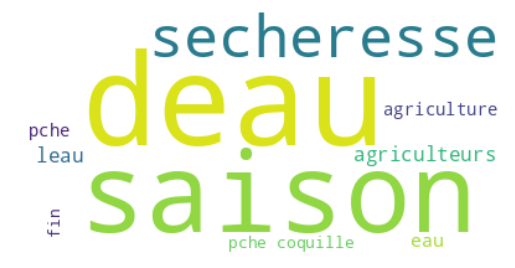

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Show wordcloud
create_wordcloud(topic_model, topic=2)